In [12]:
###################################
## Connect to a SQLite database ###
###################################
#!pip install sqlalchemy
# Import sqlalchemy's create_engine() function
from sqlalchemy import create_engine
from sqlalchemy import inspect

# Create the database engine
engine = create_engine("sqlite:///data.db")
#print(engine.table_names()) error SQLAlchemy 2.0
insp = inspect(engine)

# View the tables in the database
print(insp.get_table_names())



['boro_census', 'hpd311calls', 'weather']


In [28]:
################################
## Load entire tables        ###
################################
# Load libraries
import pandas as pd
from sqlalchemy import create_engine, text

# Create the database engine
engine = create_engine('sqlite:///data.db')
    
# Load hpd311calls without any SQL
#hpd_calls = pd.read_sql('hpd311calls', engine)
#error because the latest version of SQLAlchemy 2.0 has removed Engine.execute

#For pandas read_sql_query, to avoid an error pass a connection (not the engine) 
#and use the text function to convert the query.
conn = engine.connect()
hpd_calls = pd.read_sql_table('hpd311calls', conn)
print(hpd_calls.head())
#query = text('SELECT * FROM table')
#df = pd.read_sql_query(query, conn)

# Create a SQL query to load the entire weather table
#query = """
#SELECT * 
#  FROM weather;
#"""
# Load weather with the SQL query
#weather = pd.read_sql(query, engine) error SQLAlchemy 2.0

query = text('SELECT * FROM weather')
weather = pd.read_sql_query(query, conn)

# View the first few rows of data
print(weather.head())


  unique_key created_date agency  complaint_type incident_zip  \
0   38070822   01/01/2018    HPD  HEAT/HOT WATER        10468   
1   38065299   01/01/2018    HPD        PLUMBING        10003   
2   38066653   01/01/2018    HPD  HEAT/HOT WATER        10452   
3   38070264   01/01/2018    HPD  HEAT/HOT WATER        10032   
4   38072466   01/01/2018    HPD  HEAT/HOT WATER        11213   

       incident_address community_board    borough  
0    2786 JEROME AVENUE        07 BRONX      BRONX  
1  323 EAST   12 STREET    03 MANHATTAN  MANHATTAN  
2  1235 GRAND CONCOURSE        04 BRONX      BRONX  
3  656 WEST  171 STREET    12 MANHATTAN  MANHATTAN  
4       1030 PARK PLACE     08 BROOKLYN   BROOKLYN  
       station                         name  latitude  longitude  elevation  \
0  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
1  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
2  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898 

In [32]:
##################################
## Selecting columns with SQL ###
#################################
# Datasets can contain columns that are not required for an analysis

import pandas as pd
from sqlalchemy import create_engine, text
# Create database engine for data.db
engine = create_engine("sqlite:///data.db")

# Write query to get date, tmax, and tmin from weather
query = """
SELECT date, 
       tmax, 
       tmin
  FROM weather;
"""

# Make a dataframe by passing query and engine to read_sql()
#temperatures = pd.read_sql(query,engine) | error SQLAlchemy 2.0
conn = engine.connect()
temperatures = pd.read_sql_query(text(query), conn)

# View the resulting dataframe
print(temperatures)

#load all the columns and then use pandas to drop unwanted columns.


           date  tmax  tmin
0    12/01/2017    52    42
1    12/02/2017    48    39
2    12/03/2017    48    42
3    12/04/2017    51    40
4    12/05/2017    61    50
..          ...   ...   ...
116  03/27/2018    47    34
117  03/28/2018    52    38
118  03/29/2018    53    49
119  03/30/2018    62    44
120  03/31/2018    58    39

[121 rows x 3 columns]


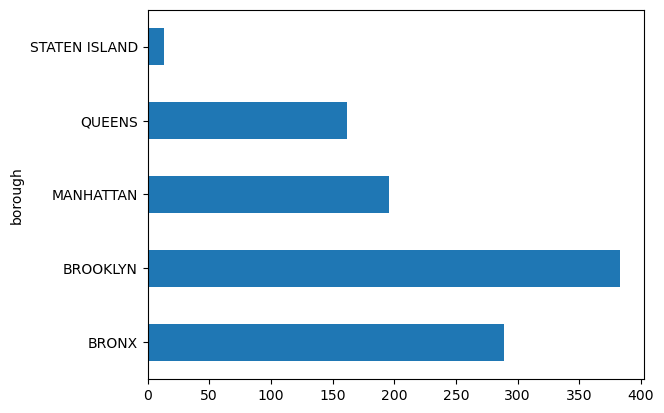

In [37]:
##################################
## Selecting rows with SQL #####
#################################
import matplotlib.pyplot as plt
# Create query to get hpd311calls records about safety
query = """
SELECT *
FROM hpd311calls
WHERE complaint_type='SAFETY';
"""

# Query the database and assign result to safety_calls
#safety_calls = pd.read_sql(query,engine) | error SQLAlchemy 2.0
conn = engine.connect()
safety_calls = pd.read_sql_query(text(query), conn)

# Graph the number of safety calls by borough
call_counts = safety_calls.groupby('borough').unique_key.count()
call_counts.plot.barh()
plt.show()

#Filtering data before importing allows focus on specific records, 
#used as a data cleaning technique it helps exclude records with known errors or missing values.


In [38]:
#########################################
## Filtering on multiple conditions #####
#########################################

# Create query for records with max temps <= 32 or snow >= 1
query = """
SELECT *
  FROM weather
  WHERE tmax <= 32
  OR snow >= 1;
"""

# Query database and assign result to wintry_days
#wintry_days = pd.read_sql(query, engine) | error SQLAlchemy 2.0
conn = engine.connect()
wintry_days = pd.read_sql_query(text(query), conn)

# View summary stats about the temperatures
print(wintry_days.describe())


           latitude     longitude     elevation       awnd      prcp  \
count  2.500000e+01  2.500000e+01  2.500000e+01  25.000000  25.00000   
mean   4.077898e+01 -7.396925e+01  4.270000e+01   7.739600   0.17600   
std    2.175584e-14  4.351168e-14  1.450389e-14   2.621778   0.36947   
min    4.077898e+01 -7.396925e+01  4.270000e+01   3.130000   0.00000   
25%    4.077898e+01 -7.396925e+01  4.270000e+01   5.820000   0.00000   
50%    4.077898e+01 -7.396925e+01  4.270000e+01   7.830000   0.00000   
75%    4.077898e+01 -7.396925e+01  4.270000e+01   9.170000   0.09000   
max    4.077898e+01 -7.396925e+01  4.270000e+01  12.970000   1.41000   

            snow       tmax       tmin  
count  25.000000  25.000000  25.000000  
mean    1.332000  27.320000  17.160000  
std     2.685256   7.122266   7.673982  
min     0.000000  13.000000   5.000000  
25%     0.000000  22.000000  11.000000  
50%     0.000000  28.000000  17.000000  
75%     1.200000  31.000000  20.000000  
max     9.800000  40.00

In [39]:
#########################################
## Getting distinct values          #####
#########################################
#duplicate values can be removed after loading data into a dataframe, 
#it can also be done at import with SQL's DISTINCT keyword.

# Create query for unique combinations of borough and complaint_type
query = """
SELECT DISTINCT borough, 
       complaint_type
  FROM hpd311calls;
"""

# Load results of query to a dataframe
#issues_and_boros = pd.read_sql(query, engine) | error SQLAlchemy 2.0
conn = engine.connect()
issues_and_boros = pd.read_sql_query(text(query), conn)

# Check assumption about issues and boroughs
print(issues_and_boros)

#easy way to find data quality issues like misspelled values 




          borough    complaint_type
0           BRONX    HEAT/HOT WATER
1       MANHATTAN          PLUMBING
2       MANHATTAN    HEAT/HOT WATER
3        BROOKLYN    HEAT/HOT WATER
4          QUEENS    HEAT/HOT WATER
..            ...               ...
60      MANHATTAN  OUTSIDE BUILDING
61      MANHATTAN          ELEVATOR
62       BROOKLYN  OUTSIDE BUILDING
63  STATEN ISLAND            SAFETY
64  STATEN ISLAND  OUTSIDE BUILDING

[65 rows x 2 columns]


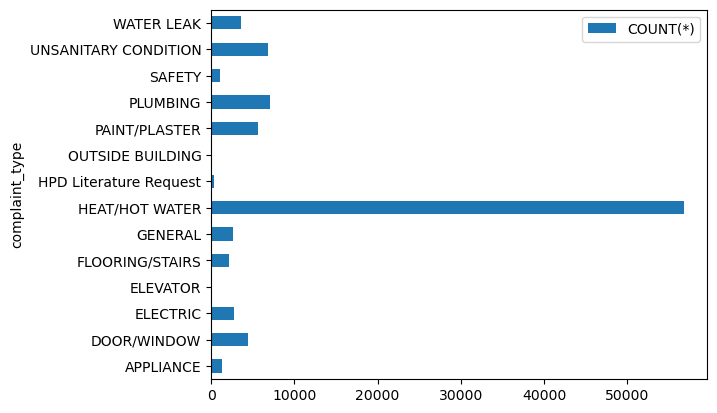

In [40]:
#########################################
## Counting in groups               #####
#########################################
#In previous exercise (Selecting rows with SQL), 
#we pulled data from tables, then summarized the resulting dataframes in pandas to create graphs. 
#By using COUNT and GROUP BY in a SQL query, we can pull those summary figures from the database directly.

# Create query to get call counts by complaint_type
query = """
SELECT complaint_type, 
     COUNT(*)
  FROM hpd311calls
  GROUP BY complaint_type;
"""

# Create dataframe of call counts by issue
#calls_by_issue = pd.read_sql(query, engine) | error SQLAlchemy 2.0
conn = engine.connect()
calls_by_issue = pd.read_sql_query(text(query), conn)

# Graph the number of calls for each housing issue
calls_by_issue.plot.barh(x="complaint_type") #horizontal bar plot
plt.show()



In [43]:
#########################################
## Working with aggregate functions #####
#########################################
#If a table contains data with higher granularity than is needed for an analysis, 
#it can make sense to summarize the data with SQL aggregate functions before importing it. 
#For example, data of flood event counts by month but precipitation data by day, 
#you may decide to SUM precipitation by month.

# Create a query to get month and max tmax by month
query = """
SELECT month, 
        MAX(tmax), 
        MIN(tmin),
        SUM(prcp)
  FROM weather 
 GROUP BY month;
"""

# Get dataframe of monthly weather stats
#weather_by_month = pd.read_sql(query, engine) | error SQLAlchemy 2.0
conn = engine.connect()
weather_by_month = pd.read_sql_query(text(query), conn)

# View weather stats by month
print(weather_by_month)

#Aggregate functions can be a useful way to summarize large datasets


      month  MAX(tmax)  MIN(tmin)  SUM(prcp)
0  December         61          9       2.21
1  February         78         16       5.83
2   January         61          5       2.18
3     March         62         27       5.17


In [45]:
#########################################
## Working with aggregate functions #####
#########################################
#build pipelines combining tables using SQL JOIN, instead of having to combine data after importing it.

# Query to join weather to call records by date columns
query = """
SELECT * 
  FROM hpd311calls
  JOIN weather 
  ON hpd311calls.created_date = weather.date;
"""

# Create dataframe of joined tables
#calls_with_weather = pd.read_sql(query,engine)| error SQLAlchemy 2.0
conn = engine.connect()
calls_with_weather = pd.read_sql_query(text(query), conn)

# View the dataframe to make sure all columns were joined
print(calls_with_weather.head())


  unique_key created_date agency  complaint_type incident_zip  \
0   38070822   01/01/2018    HPD  HEAT/HOT WATER        10468   
1   38065299   01/01/2018    HPD        PLUMBING        10003   
2   38066653   01/01/2018    HPD  HEAT/HOT WATER        10452   
3   38070264   01/01/2018    HPD  HEAT/HOT WATER        10032   
4   38072466   01/01/2018    HPD  HEAT/HOT WATER        11213   

       incident_address community_board    borough      station  \
0    2786 JEROME AVENUE        07 BRONX      BRONX  USW00094728   
1  323 EAST   12 STREET    03 MANHATTAN  MANHATTAN  USW00094728   
2  1235 GRAND CONCOURSE        04 BRONX      BRONX  USW00094728   
3  656 WEST  171 STREET    12 MANHATTAN  MANHATTAN  USW00094728   
4       1030 PARK PLACE     08 BROOKLYN   BROOKLYN  USW00094728   

                          name  ...  longitude  elevation        date  \
0  NY CITY CENTRAL PARK, NY US  ...  -73.96925       42.7  01/01/2018   
1  NY CITY CENTRAL PARK, NY US  ...  -73.96925       42.7  0

In [49]:
#########################################
## Joining and filtering            #####
#########################################
#you might not want all columns and rows that result from a JOIN

# Query to get hpd311calls and precipitation values
query = """
SELECT hpd311calls.*, weather.prcp
  FROM hpd311calls
  JOIN weather
    ON hpd311calls.created_date = weather.date
  WHERE hpd311calls.complaint_type = 'WATER LEAK';"""

# Load query results into the leak_calls dataframe
#leak_calls = pd.read_sql(query,engine)  error SQLAlchemy 2.0
conn = engine.connect()
leak_calls = pd.read_sql_query(text(query), conn)

# View the dataframe
print(leak_calls.head())

#with very big tables, filter or aggregate the data first before attempting a join.


  unique_key created_date agency complaint_type incident_zip  \
0   38074305   01/01/2018    HPD     WATER LEAK        11212   
1   38078748   01/01/2018    HPD     WATER LEAK        10458   
2   38081097   01/01/2018    HPD     WATER LEAK        11221   
3   38077874   01/01/2018    HPD     WATER LEAK        11418   
4   38081110   01/01/2018    HPD     WATER LEAK        11420   

          incident_address community_board   borough  prcp  
0     1026 WILLMOHR STREET     17 BROOKLYN  BROOKLYN   0.0  
1       2700 MARION AVENUE        07 BRONX     BRONX   0.0  
2  192 MALCOLM X BOULEVARD     03 BROOKLYN  BROOKLYN   0.0  
3    129-11 JAMAICA AVENUE       09 QUEENS    QUEENS   0.0  
4        111-17 133 STREET       10 QUEENS    QUEENS   0.0  


In [50]:
##############################################
## Joining, filtering, and aggregating   #####
##############################################
# Modify query to join tmax and tmin from weather by date

query = """
SELECT hpd311calls.created_date, 
	   COUNT(*), 
       weather.tmax,
       weather.tmin
  FROM hpd311calls 
       JOIN weather
       ON hpd311calls.created_date = weather.date
 WHERE hpd311calls.complaint_type = 'HEAT/HOT WATER' 
 GROUP BY hpd311calls.created_date;
 """
# Load query results into the leak_calls dataframe
#leak_calls = pd.read_sql(query,engine)  error SQLAlchemy 2.0
conn = engine.connect()
df = pd.read_sql_query(text(query), conn)

# View the dataframe
print(df.head())

#While SQL joins can only be used in databases, there are analagous pandas operations to combine datasets.

  created_date  COUNT(*)  tmax  tmin
0   01/01/2018      4597    19     7
1   01/02/2018      4362    26    13
2   01/03/2018      3045    30    16
3   01/04/2018      3374    29    19
4   01/05/2018      4333    19     9
